In [4]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense ,GlobalAveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np 
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [6]:

train_generator = train_datagen.flow_from_directory(
    "data//training_set",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 1600 images belonging to 2 classes.


In [12]:
(x_train , y_train) = train_generator[1]

In [15]:
x_train.shape
y_train.shape

(32,)

In [32]:
image_size = (256, 256)
batch_size = 128
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data//training_set',
    validation_split=0.01,
    color_mode='rgb',
    label_mode='binary',
    subset='training',
    seed=13372,
    image_size=image_size,
    batch_size=batch_size)

train_size = int(0.8 * dataset.cardinality().numpy())
valid_size = dataset.cardinality().numpy() - train_size
train_ds = dataset.take(train_size)
valid_ds = dataset.skip(train_size)

Found 1600 files belonging to 2 classes.
Using 1584 files for training.


In [33]:
train_data=[batch for batch in train_ds.unbatch()]
X_train , y_train = zip(*train_data)
X_train =np.array(X_train)
y_train =np.array(y_train)

In [34]:
print(X_train.shape)
print(y_train.shape)

(1280, 256, 256, 3)
(1280, 1)


In [35]:
valid_data=[batch for batch in valid_ds.unbatch()]
X_val , y_val = zip(*valid_data)
X_val =np.array(X_val)
y_val =np.array(y_val)

In [36]:
print(X_val.shape)
print(y_val.shape)

(304, 256, 256, 3)
(304, 1)


In [37]:
def ResNet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(units, activation='softmax')(x)

    model = Model(inputs, x)
    return model

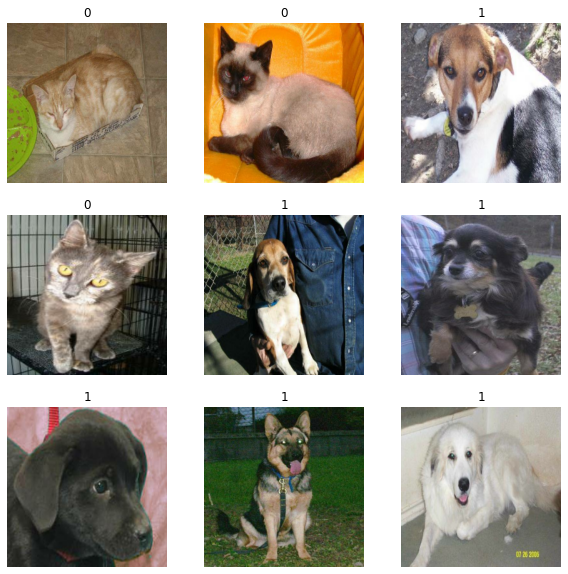

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [60]:
input_shape=(256,256,3)
num_classes=2
model = ResNet18(input_shape, num_classes)

In [61]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_24 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_24 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_25 (Activation)   (None, 256, 256, 64)      0   

In [62]:
epochs = 5

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [56]:
model = KerasClassifier(build_fn=model, epochs=epochs, batch_size=32, verbose=0)

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds
)

Epoch 1/5
